#### Objetivo del proceso de análisis
El objetivo de este proceso es proporcionar información valiosa a la compañía contratante sobre las películas incluidas en la base de datos, para así poder identificar los patrones y tendencias que estén relacionados con el éxito y recepción de una película.

#### Base de datos - 943.76 MB
El dataset a analizar se encuentra en formato CSV, y se compone de los siguientes siete archivos:

- movies_metadata.csv: Es el archivo principal de metadatos de películas. Contiene información sobre las 45.000 películas incluidas en el conjunto de datos completo de MovieLens. Incluye información como presupuesto, ingresos, fechas de lanzamiento, idiomas, países de producción, compañías de producción y más.
- keywords.csv: Contiene palabras clave (keywords) de tramas para las películas.
- credits.csv: Contiene información de reparto y equipo técnico para todas las películas.
- links.csv: Contiene los identificadores TMDB e IMDB de todas las películas incluidas en el conjunto de datos.
- links_small.csv: Es una versión reducida del archivo links.csv y solo contiene los identificadores TMDB e IMDB de un subconjunto de 9.000 películas.
- ratings_small.csv: Es una versión reducida del archivo ratings.csv y contiene una muestra de 100.000 calificaciones de 700 usuarios para un subconjunto de 9.000 películas.
- ratings.csv: Contiene 26 millones de calificaciones de 270.000 usuarios para todas las 45.000 películas incluidas en el conjunto de datos completo. Las calificaciones se proporcionan en una escala de 1 a 5 y se han obtenido del sitio web oficial de GroupLens.

#### Visual Studio Notebooks Python y Conda Environments
Para realizar el análisis exploratorio de los datos, se utilizará Visual Studio Notebooks Python, que es una herramienta que permite la creación de notebooks de Jupyter en un entorno integrado de desarrollo. Este ambiente permitirá la exploración interactiva de los datos y la creación de visualizaciones con bibliotecas como Plotly.

Además, se creará un ambiente de programación con Conda, que permitirá la gestión de las dependencias y versiones de las bibliotecas utilizadas en el proceso analítico.

#### Visualización con Dash
Visualización con Dash
Una vez que hayamos realizado nuestro análisis exploratorio, utilizaremos Dash para crear visualizaciones interactivas que permitan a los usuarios explorar los datos por sí mismos. Esto incluirá gráficos interactivos y tablas que permitan a los usuarios filtrar y ordenar los datos para descubrir patrones interesantes.

En resumen, nuestro análisis de los datos de películas de MovieLens ayudará a la productora a entender mejor el mercado cinematográfico y tomar decisiones informadas sobre la producción y comercialización de películas.

#### Inicio del proceso de análisis

#### Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sqlalchemy
import random
import json
import datetime
import ast
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sqlalchemy import create_engine


### No olvida instalar:  pip install wordcloud

#### Conexión con AWS

In [2]:
host = "ejercicio-1.ctcgld8nnmsr.us-east-1.rds.amazonaws.com"
port = '5432'
user = 'postgres'
password = 'ju*n0411'
database = 'postgres'

connAlchemy = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
conn = connAlchemy.raw_connection()
cur = conn.cursor()

#### Cargue de la base de datos tanto local como AWS

In [3]:
rating_data = pd.read_sql('SELECT id, rating from movies_rating', connAlchemy) #26milones de registros
rating_data.shape

(26024289, 2)

In [4]:
metadata = pd.read_csv('Movies_dataset/movies_metadata.csv', low_memory=False)

Como se mencionaba abteriormente, los datos corresponden a 26 millines de calificaciones de de 45,000 películas de 27,000 usuarios.

#### Exploración de la base de datos: Entendiendo los datos y sus características

Iniciaremos el análisis con __movies_metadata__ y __ratings__.

El primero tiene un total de **45,446 películas**, cada una con **24 características**, siendo éstas:


Por el otro lado, __ratings__ cuenta con 26 millones de calificaciones para las 45 mil películas del dataset.

Key features:
- **id**: El ID de la película.
- **imdb_id**: El ID de IMDB de la película.
- **vote_average**: La calificación promedio de la película.
- **vote_count**: El número de votos de los usuarios, según lo contado por TMDB.

Cuantitativas:
- **budget**: El presupuesto de la película en dólares.
- **popularity**: La puntuación de popularidad asignada por TMDB.
- **revenue**: Los ingresos totales de la película en dólares.

Boleanas:
- **adult**: Indica si la película es X-Rated o para adultos.
Categóridas:
- **belongs_to_collection**: Un diccionario en forma de cadena que proporciona información sobre la serie de películas a la que pertenece la película en particular.
- **genres**: Una lista de diccionarios en forma de cadena que enumeran todos los géneros asociados con la película.
- **original_title**: El título original de la película.
- **original_language**: El idioma en el que se filmó originalmente la película.
- **overview**: Una breve descripción de la película.
- **production_companies**: Una lista en forma de cadena de las compañías de producción involucradas en la realización de la película.
- **production_countries**: Una lista en forma de cadena de los países donde se filmó/produjo la película.
- **spoken_languages**: Una lista en forma de cadena de los idiomas hablados en la película.
- **status**: El estado de la película (Estrenada, Por estrenar, Anunciada, etc.).
- **tagline**: El lema de la película.
- **title**: El título oficial de la película.

Tiempo:
- **release_date**: Fecha de estreno en cines de la película.
- **runtime**: La duración de la película en minutos.

Infromación complementaria:
- **homepage**: La página de inicio oficial de la película.
- **poster_path**: La URL de la imagen del póster.
- **video**: Indica si hay un video presente de la película en TMDB.


#### Tratamiento de datos

In [5]:
metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

Al haber solo 9 película para adultos, eliminaremos ésta columna

In [6]:
metadata = metadata.drop('adult', axis=1)

In [7]:
metadata = metadata.drop('homepage', axis=1)

In [8]:
metadata = metadata.drop('video', axis=1)

In [9]:
metadata = metadata.drop('original_title', axis=1) #Dado que están en idiomas diferentes a inglés

In [10]:
metadata['revenue'] = metadata['revenue'].replace(0, np.nan)

Dado que hay valores de diferente formato dentro de presupuesto, antes de reemplazar los null por 0, nos aseguraremos de haberlos estandarizado todos a valores numéricos

In [11]:
metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
metadata['budget'] = metadata['budget'].replace(0, np.nan)
metadata[metadata['budget'].isnull()].shape

(36576, 20)

Creación de feature: ***Ganancia = Ingreso - Presupuesto***. Esto para poder realizar anális más significativos y precisos para obtener una idea del éxito financiero de la película

In [12]:
metadata['return'] = metadata['revenue'] / metadata['budget']

Creación de una nueva feature llamada **Year** que contenta unicamente el año de la columna release_date

In [13]:
metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

#### Relación entre localy AWS

El valor promedio por pélicula

In [14]:
r_promedio = rating_data.groupby('id')['rating'].mean().reset_index()
r_promedio.columns = ['id', 'average_rating']

Unión de la columna de calificación promedio con metadata

In [15]:
metadata = metadata.merge(r_promedio, on="id")

Extracción de columnas que se van a relacionar con la calificación promedio

In [17]:
rela_rev_rat = metadata.loc[:,["title","budget","revenue","average_rating","popularity"]]
rela_rev_rat

,title,budget,revenue,average_rating,popularity
0,Toy Story,30000000.0,373554033.0,3.598930,21.946943
1,Jumanji,65000000.0,262797249.0,3.760163,17.015539
2,Heat,60000000.0,187436818.0,3.905544,17.924927
3,GoldenEye,58000000.0,352194034.0,2.740334,14.686036
4,Cutthroat Island,98000000.0,10017322.0,3.710181,7.284477
...,...,...,...,...,...
7564,Cinderella,NaN,NaN,3.795053,0.803588
7565,Šíleně smutná princezna,NaN,NaN,3.126140,0.375001
7566,The Final Storm,NaN,NaN,2.791667,1.270832
7567,The One-Man Band,NaN,NaN,3.390625,1.109068


Correlación entre la califciación promedio y los ingresos

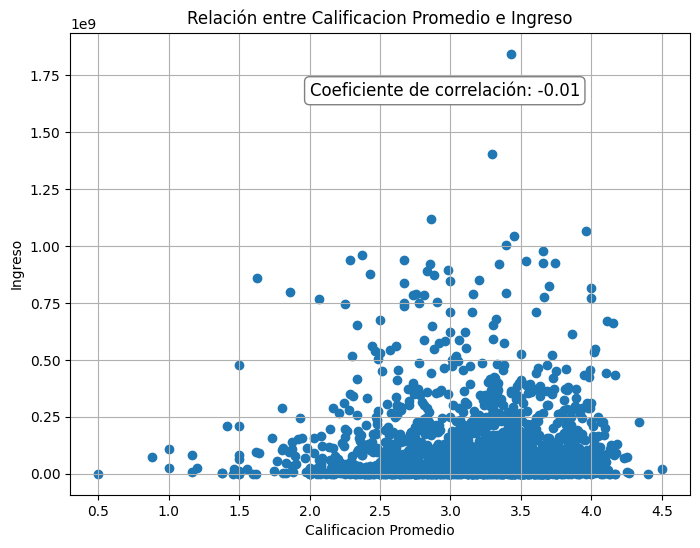

In [18]:
df_cleaned_1 = rela_rev_rat.dropna(subset=['average_rating', 'revenue'])
x = df_cleaned_1['average_rating'].values
y = df_cleaned_1['revenue'].values
pearson_coef, _ = stats.pearsonr(x, y)

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel('Calificacion Promedio')
plt.ylabel('Ingreso')
plt.title('Relación entre Calificacion Promedio e Ingreso')
plt.grid(True)
plt.text(2, 0.9*np.max(y), f"Coeficiente de correlación: {pearson_coef:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
plt.show()

Correlación entre la calificación promedio y el presupuesto

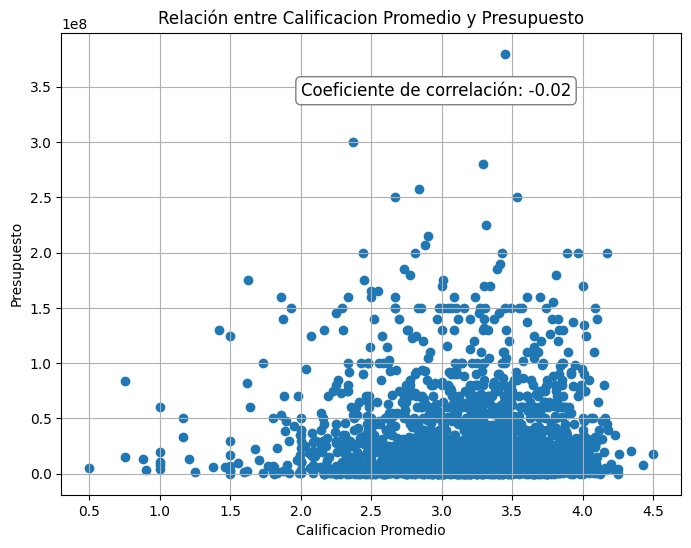

In [19]:
df_cleaned_2 = rela_rev_rat.dropna(subset=['average_rating', 'budget'])
x = df_cleaned_2['average_rating'].values
y = df_cleaned_2['budget'].values
pearson_coef, _ = stats.pearsonr(x, y)

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel('Calificacion Promedio')
plt.ylabel('Presupuesto')
plt.title('Relación entre Calificacion Promedio y Presupuesto')
plt.grid(True)
plt.text(2, 0.9*np.max(y), f"Coeficiente de correlación: {pearson_coef:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
plt.show()

Correlación entre la califiicación promedio y la popularidad

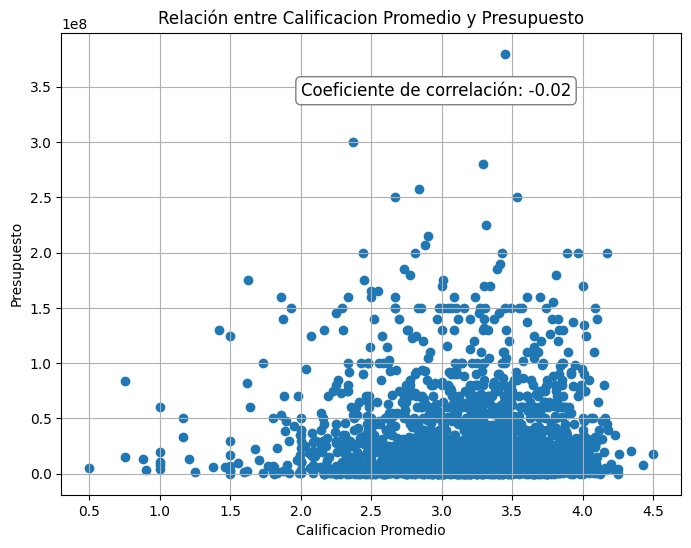

In [20]:
df_cleaned_2 = rela_rev_rat.dropna(subset=['average_rating', 'budget'])
x = df_cleaned_2['average_rating'].values
y = df_cleaned_2['budget'].values
pearson_coef, _ = stats.pearsonr(x, y)

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel('Calificacion Promedio')
plt.ylabel('Presupuesto')
plt.title('Relación entre Calificacion Promedio y Presupuesto')
plt.grid(True)
plt.text(2, 0.9*np.max(y), f"Coeficiente de correlación: {pearson_coef:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
plt.show()

Filtrar dataset para que aparezcan películas que tengan más de 1000 votos

In [21]:
metadata_filtrado = metadata[metadata['vote_count'] > 1000]

Top 10 películas con mejores calificaciones

In [22]:
metadata_filtrado[['title', 'average_rating', 'year','vote_count']].sort_values('average_rating', ascending=False).head(10)

,title,average_rating,year,vote_count
1667,Terminator 3: Rise of the Machines,4.169975,2003,2177.0
2662,Ice Age: The Meltdown,4.150083,2006,3034.0
2337,Oldboy,4.112805,2003,2000.0
798,The Sixth Sense,4.112609,1999,3223.0
2880,Zodiac,4.110604,2007,2080.0
1444,Men in Black II,4.105347,2002,3188.0
1178,Scarface,4.089309,1983,3017.0
2866,Ghost Rider,4.083449,2007,1754.0
576,Lethal Weapon 2,4.069184,1989,1066.0
613,Beetlejuice,4.060505,1988,1475.0


#### Apliación de analítica sobre el dataframe

##### Países Productores

In [23]:
metadata['production_countries'] = metadata['production_countries'].fillna('[]').apply(ast.literal_eval)
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else json.loads(x) if isinstance(x, str) else [])

En esta línea de código, se rellenan los valores faltantes de la columna 'production_countries' con '[]' (una cadena vacía que representa una lista vacía). Luego, se aplica la función ast.literal_eval() a cada valor de la columna para evaluarlo como una expresión de Python. Esto convierte las cadenas de texto que representan listas en listas reales de Python.

Luego se aplica una lambda función a cada valor de la columna 'production_countries'. Si el valor es una lista, se crea una nueva lista que contiene los valores de la clave 'name' de cada diccionario en la lista original. Si el valor es una cadena de texto, se utiliza json.loads() para analizar la cadena y convertirla en una lista. Si el valor no es ni una lista ni una cadena de texto, se asigna una lista vacía.

In [24]:
s = metadata.apply(lambda x: pd.Series(x['production_countries']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'
s = s.astype('object')

C:\Users\Asus\AppData\Local\Temp\ipykernel_20068\2156412367.py:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Aquí creamos una nueva serie llamada 'countries' a partir de la columna 'production_countries' del DataFrame 'metadata'. La serie 'countries' contiene los valores de los países de producción de las películas, y se genera mediante la función apply() y stack(). En esta línea de código, se utiliza apply() para aplicar una lambda función a cada fila del DataFrame metadata. La lambda función extrae la columna 'production_countries' de cada fila y crea una Serie de pandas. Luego, se utiliza stack() para apilar todas las Series resultantes en una sola Serie. Finalmente, se utiliza reset_index() para eliminar el índice secundario y dejar solo el índice principal.

In [25]:
con_df = metadata.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)

con_df.rename(columns={'num_movies': 'Películas', 'country': 'País'}).head(10)

,Películas,País
0,3822,United States of America
1,849,France
2,784,United Kingdom
3,585,Germany
4,434,Italy
5,264,Japan
6,239,Canada
7,176,Spain
8,126,Russia
9,109,Sweden


##### Key Words, Título y Descripción 

In [26]:
keywords = pd.read_csv('Movies_dataset/keywords.csv')
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [28]:
def extract_names(cadena):
    lista_diccionarios = ast.literal_eval(cadena)
    nombres = [diccionario['name'] for diccionario in lista_diccionarios]
    return nombres
keywords['extracted_names'] = keywords['keywords'].apply(extract_names)


In [29]:
print(keywords['extracted_names'])

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
46414                                        [tragic love]
46415                                [artist, play, pinoy]
46416                                                   []
46417                                                   []
46418                                                   []
Name: extracted_names, Length: 46419, dtype: object


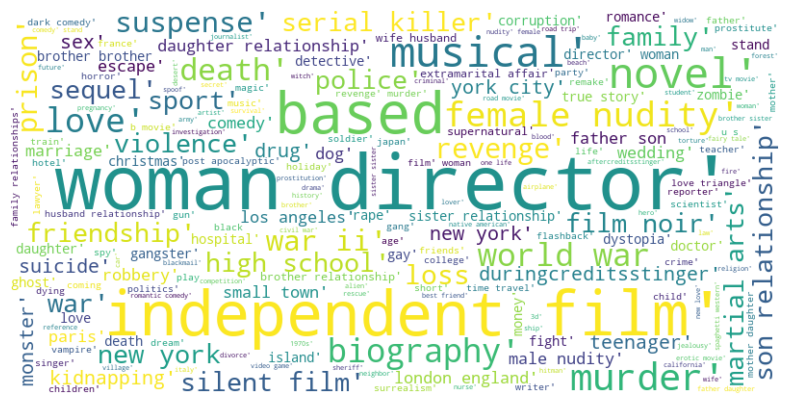

In [30]:
keywords['extracted_names'] = keywords['extracted_names'].astype('str')
key_corpus = ' '.join(keywords['extracted_names'])

keywords_df = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(key_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(keywords_df, interpolation='bilinear')
plt.axis('off')
plt.show()

Continuareamos por visulaizar las palabras más populares presentes en las descripciones de las películas

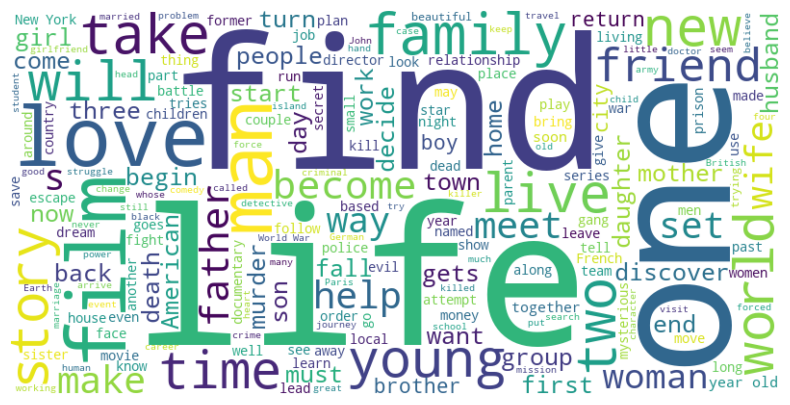

In [31]:
metadata['overview'] = metadata['overview'].astype('str')
overview_corpus = ' '.join(metadata['overview'])

overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(overview_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(overview_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ahora en sus títulos

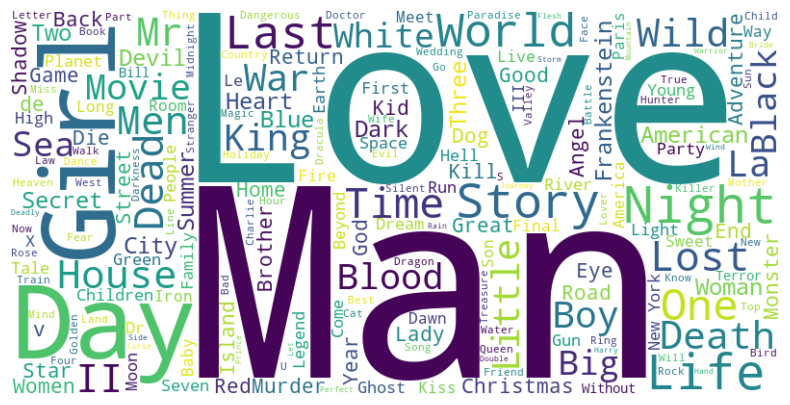

In [32]:
metadata['title'] = metadata['title'].astype('str')
title_corpus = ' '.join(metadata['title'])

title_corpus = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(title_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(title_corpus, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Películas por franquicia

In [33]:
franquicia_dataframe = metadata[metadata['belongs_to_collection'].notnull()]
franquicia_dataframe['belongs_to_collection'] = franquicia_dataframe['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
franquicia_dataframe = franquicia_dataframe[franquicia_dataframe['belongs_to_collection'].notnull()]

C:\Users\Asus\AppData\Local\Temp\ipykernel_20068\215530321.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
pivotado_franquicia = franquicia_dataframe.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [35]:
pivotado_franquicia = pivotado_franquicia.rename(columns={'belongs_to_collection': 'Franquicia', 'count': 'Películas', 'mean': 'Media', 'sum': 'Suma'})
pivotado_franquicia.sort_values('Suma', ascending=False)
pivotado_franquicia.head(8)

,Franquicia,Películas,Media,Suma
0,00 Schneider Filmreihe,0,NaN,0.0
1,2 Days In... Collection,1,19776159.0,19776159.0
2,20th Century Boys Collection,1,31244858.0,31244858.0
3,28 Days/Weeks Later Collection,2,73479162.5,146958325.0
4,3 Men (Original) Collection,1,2052466.0,2052466.0
5,3 Ninjas Collection,0,NaN,0.0
6,30 Days of Night Collection,1,75505973.0,75505973.0
7,300 Collection,1,422610419.0,422610419.0


In [36]:
pivotado_franquicia.sort_values('Media', ascending=False).head(10)

,Franquicia,Películas,Media,Suma
423,The Avengers Collection,1,1.405404e+09,1.405404e+09
481,The Lord of the Rings Collection,3,9.721816e+08,2.916545e+09
154,Finding Nemo Collection,1,9.403355e+08,9.403355e+08
322,Pirates of the Caribbean Collection,4,9.318462e+08,3.727385e+09
192,Harry Potter Collection,6,9.018436e+08,5.411062e+09
393,Spider-Man Collection,2,8.373190e+08,1.674638e+09
218,Independence Day Collection,1,8.169693e+08,8.169693e+08
478,The Lion King Collection,1,7.882418e+08,7.882418e+08
184,Guardians of the Galaxy Collection,1,7.733286e+08,7.733286e+08
546,Transformers Collection,2,7.730035e+08,1.546007e+09


##### Compañías productoras

In [37]:
metadata['production_companies'] = metadata['production_companies'].fillna('[]').apply(ast.literal_eval)
metadata['production_companies'] = metadata['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [38]:
s = metadata.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

C:\Users\Asus\AppData\Local\Temp\ipykernel_20068\162676989.py:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [39]:
com_df = metadata.drop('production_companies', axis=1).join(s)

In [40]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

Compañias con la mayor generación de ganancias TOP 10

In [41]:
com_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
companies,,,
Warner Bros.,3.137711e+10,1.696060e+08,185
Paramount Pictures,2.358087e+10,1.649012e+08,143
Universal Pictures,2.251664e+10,1.481358e+08,152
Twentieth Century Fox Film Corporation,1.988863e+10,1.699883e+08,117
DreamWorks SKG,1.133829e+10,2.699592e+08,42
Amblin Entertainment,1.125201e+10,2.885130e+08,39
Columbia Pictures,1.054022e+10,1.700035e+08,62
Walt Disney Pictures,1.012033e+10,4.819207e+08,21
New Line Cinema,8.347787e+09,1.517780e+08,55


Anora, con el parámetro ingreso (reutrn), y el cálculo del promedio de éste veremeos el éxto real de las casas productoras

In [42]:
com_pivot[com_pivot['Number'] >= 15].sort_values('Average', ascending=False).head(10)

,Total,Average,Number
companies,,,
Walt Disney Pictures,1.012033e+10,4.819207e+08,21
Amblin Entertainment,1.125201e+10,2.885130e+08,39
DreamWorks SKG,1.133829e+10,2.699592e+08,42
Silver Pictures,3.893405e+09,1.946702e+08,20
Village Roadshow Pictures,6.310941e+09,1.856159e+08,34
Columbia Pictures,1.054022e+10,1.700035e+08,62
Twentieth Century Fox Film Corporation,1.988863e+10,1.699883e+08,117
Warner Bros.,3.137711e+10,1.696060e+08,185
Eon Productions,2.877450e+09,1.692617e+08,17


##### Lenguaje Original

In [43]:
metadata['original_language'].drop_duplicates().shape[0]

57

In [44]:
lang_metadata = pd.DataFrame(metadata['original_language'].value_counts())
lang_metadata['language'] = lang_metadata.index
lang_metadata.columns = ['number', 'language']


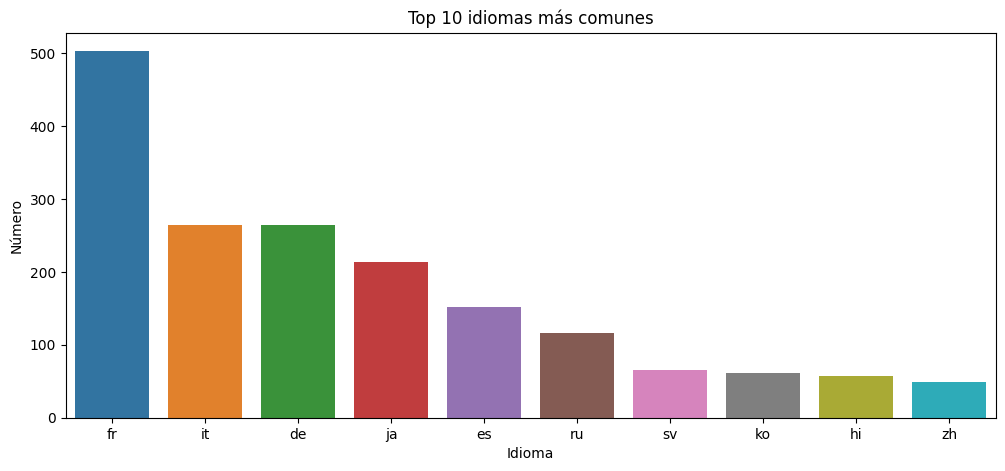

In [45]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_metadata.iloc[1:11])
plt.xlabel('Idioma')
plt.ylabel('Número')
plt.title('Top 10 idiomas más comunes')
plt.show()

##### Popularidad

Top 10 películas más famosas

In [46]:
def transfromacion_numerica(x):
    try:
        return float(x)
    except:
        return np.nan

In [47]:
metadata['popularity'] = metadata['popularity'].apply(transfromacion_numerica).astype('float')
metadata['vote_count'] = metadata['vote_count'].apply(transfromacion_numerica).astype('float')
metadata['vote_average'] = metadata['vote_average'].apply(transfromacion_numerica).astype('float')

In [48]:
metadata[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10).rename(columns={'title': 'Título', 'popularity': 'Popularidad', 'year': 'Año'})

,Título,Popularidad,Año
80,Pulp Fiction,140.950236,1994
3134,The Dark Knight,123.167259,2008
148,Blade Runner,96.272374,1982
4977,Dawn of the Planet of the Apes,75.385211,2014
839,Fight Club,63.869599,1999
4989,Guardians of the Galaxy,53.291601,2014
88,The Shawshank Redemption,51.645403,1994
97,Forrest Gump,48.307194,1994
1669,Pirates of the Caribbean: The Curse of the Bla...,47.326665,2003
69,Star Wars,42.149697,1977



##### Votación

Promedio de votación

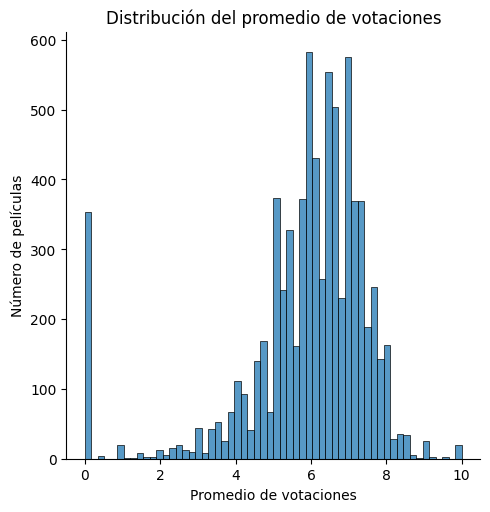

In [49]:
sns.displot(metadata['vote_average'].fillna(metadata['vote_average'].median()))
plt.xlabel('Promedio de votaciones')
plt.ylabel('Número de películas')
plt.title('Distribución del promedio de votaciones')
plt.show()

Top 10 películas más votadas

In [50]:
metadata[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
3619,Inception,14075.0,2010
3134,The Dark Knight,12269.0,2008
4860,Interstellar,11187.0,2014
4989,Guardians of the Galaxy,10014.0,2014
839,Fight Club,9678.0,1999
729,The Matrix,9079.0,1999
3157,Iron Man,8951.0,2008
1342,The Lord of the Rings: The Fellowship of the Ring,8892.0,2001
80,Pulp Fiction,8670.0,1994
88,The Shawshank Redemption,8358.0,1994


Películas mejor votadas

In [51]:
metadata[metadata['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
210,The Godfather,8.5,6024.0,1972
88,The Shawshank Redemption,8.5,8358.0,1994
320,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
342,The Godfather: Part II,8.3,3418.0,1974
340,Psycho,8.3,2405.0,1960
661,Life Is Beautiful,8.3,3643.0,1997
839,Fight Club,8.3,9678.0,1999
1478,Spirited Away,8.3,3968.0,2001
80,Pulp Fiction,8.3,8670.0,1994
3134,The Dark Knight,8.3,12269.0,2008


Identificación entre popularidad y media de votaciones

Método a usar para evaluar correlación: El coeficiente de correlación de Pearson, también conocido como coeficiente de correlación lineal, es una medida que indica la fuerza y la dirección de la relación lineal entre dos variables continuas.
Cuando se trata de determinar si un coeficiente de Pearson es mucho o poco significativo, generalmente se consideran los siguientes rangos:

- Magnitud cercana a 1: Indica una correlación fuerte.
- Magnitud cercana a 0.7 u 0.8: Indica una correlación moderada.
- Magnitud cercana a 0.5: Indica una correlación débil.
- Magnitud cercana a 0: Indica una correlación muy débil o nula.

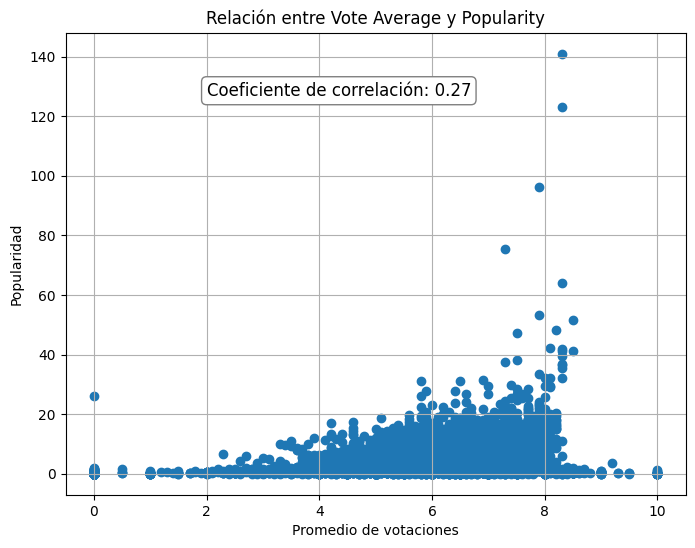

In [52]:
df_cleaned = metadata.dropna(subset=['vote_average', 'popularity'])
x = df_cleaned['vote_average'].values
y = df_cleaned['popularity'].values
pearson_coef, _ = stats.pearsonr(x, y)

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel('Promedio de votaciones')
plt.ylabel('Popularidad')
plt.title('Relación entre Vote Average y Popularity')
plt.grid(True)
plt.text(2, 0.9*np.max(y), f"Coeficiente de correlación: {pearson_coef:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
plt.show()

##### Fechas de lanzamientos de películas

In [53]:
def extraer_mes(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [54]:
def extraer_día(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [55]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

metadata['dia'] = metadata['release_date'].apply(extraer_día)
metadata['mes'] = metadata['release_date'].apply(extraer_mes)

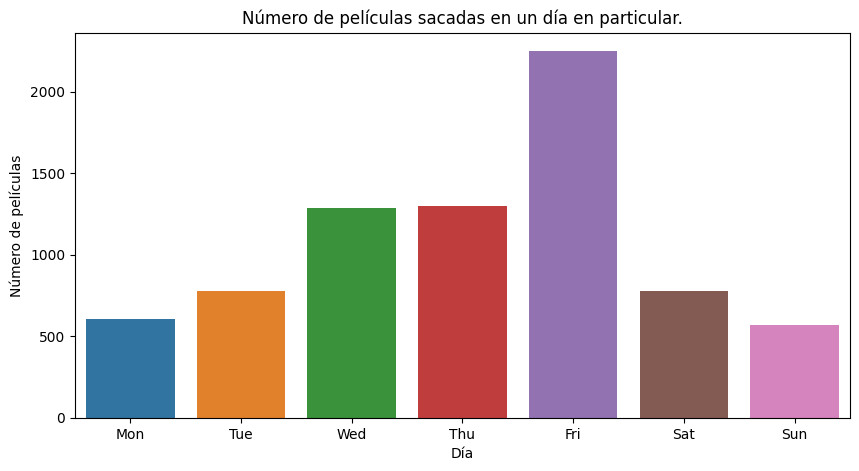

In [56]:
plt.figure(figsize=(10, 5))
plt.title("Número de películas sacadas en un día en particular.")
sns.countplot(x='dia', data=metadata, order=day_order)
plt.xlabel("Día")
plt.ylabel("Número de películas")
plt.show()

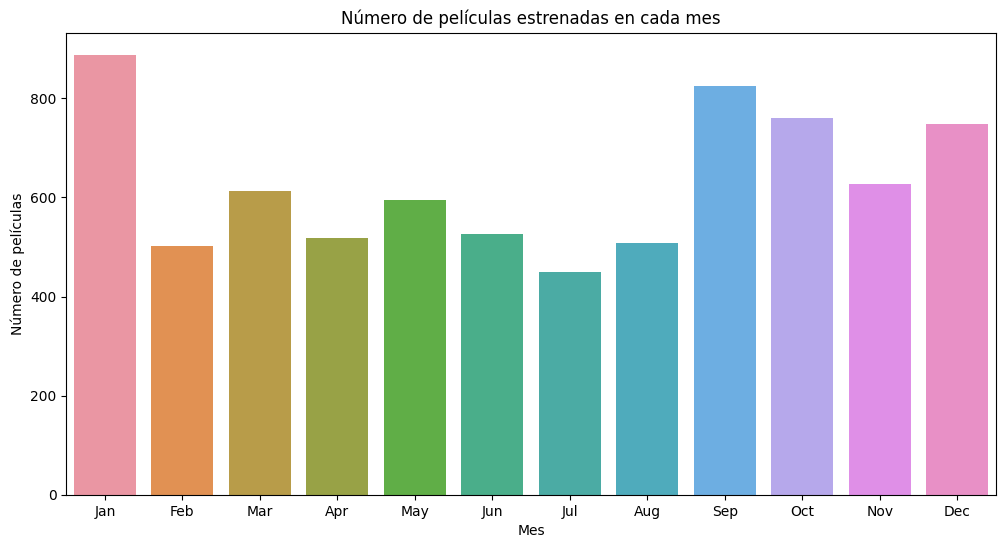

In [57]:
plt.figure(figsize=(12, 6))
plt.title("Número de películas estrenadas en cada mes")
sns.countplot(x='mes', data=metadata, order=month_order)
plt.xlabel("Mes")
plt.ylabel("Número de películas")
plt.show()

Ahora queremos saber en qué meses salen las películas que generan mayor ganancia

<Axes: title={'center': 'Promedio de ganancia por película en cada mes'}, xlabel='mes', ylabel='revenue'>

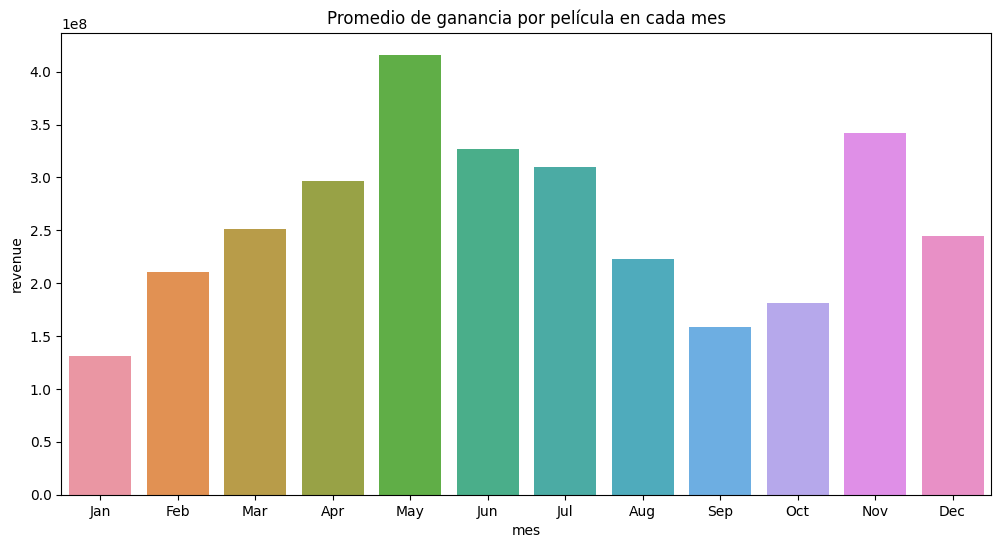

In [58]:
month_mean = pd.DataFrame(metadata[metadata['revenue'] > 1e8].groupby('mes')['revenue'].mean())
month_mean['mes'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Promedio de ganancia por película en cada mes")
sns.barplot(x='mes', y='revenue', data=month_mean, order=month_order)

Utilizando la fecha de la lanzamiento y mediante la frecuencia de películas, queremos identificar en qué año salió el mayor número de películas

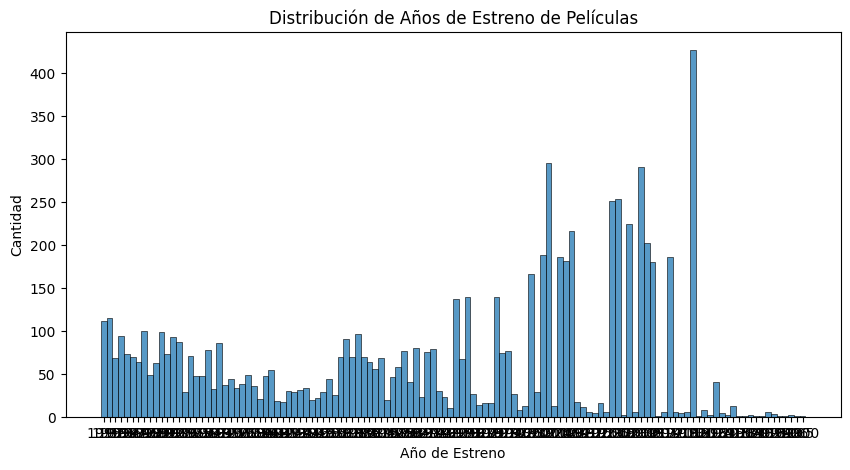

In [59]:
plt.figure(figsize=(10, 5))
sns.histplot(metadata['year'], bins=np.arange(1900, 2019, 1))
plt.title('Distribución de Años de Estreno de Películas')
plt.xlabel('Año de Estreno')
plt.ylabel('Cantidad')
plt.show()

##### Duración

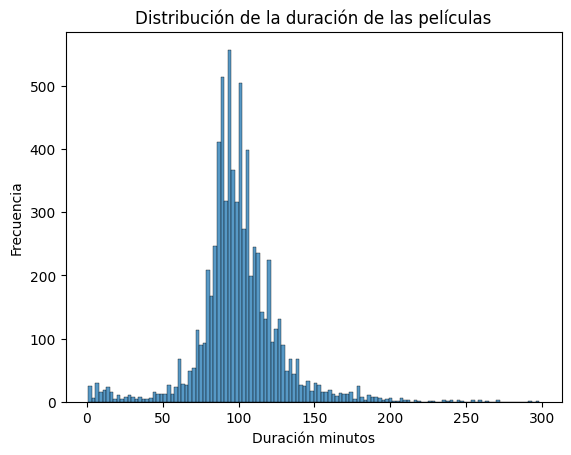

In [60]:
metadata['runtime'] = metadata['runtime'].astype('float')
filtered_runtime = metadata[(metadata['runtime'] < 300) & (metadata['runtime'] > 0)]['runtime']
# Crear el gráfico de histograma
sns.histplot(filtered_runtime)
# Establecer título y etiquetas de los ejes
plt.title('Distribución de la duración de las películas')
plt.xlabel('Duración minutos')
plt.ylabel('Frecuencia')
# Mostrar el gráfico
plt.show()

##### Ganancia

Películas más Exitosas

In [61]:
resultado = metadata[(metadata['return'].notnull()) & (metadata['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False)
nombres_columnas = {'title': 'Título', 'budget': 'Presupuesto', 'revenue': 'Ingresos', 'return': 'Ganancia', 'year': 'Año'}
resultado = resultado.rename(columns=nombres_columnas)
resultado.head(10)

,Título,Presupuesto,Ingresos,Ganancia,Año
286,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
69,Star Wars,11000000.0,775398007.0,70.490728,1977
98,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
210,The Godfather,6000000.0,245066411.0,40.844402,1972
281,Dirty Dancing,6000000.0,213954274.0,35.659046,1987
161,Pretty Woman,14000000.0,463000000.0,33.071429,1990
3077,Juno,7500000.0,231411584.0,30.854878,2007
428,Grease,6000000.0,181813770.0,30.302295,1978
321,The Empire Strikes Back,18000000.0,538400000.0,29.911111,1980
687,Rocky II,7000000.0,200182160.0,28.597451,1979


Desastres en taquilla

In [62]:
resultado = metadata[(metadata['return'].notnull()) & (metadata['budget'] > 5e6) & (metadata['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return')
nombres_columnas = {'title': 'Título', 'budget': 'Presupuesto', 'revenue': 'Ingresos', 'return': 'Ganancia', 'year': 'Año'}
resultado = resultado.rename(columns=nombres_columnas)
resultado.head(10)

,Título,Presupuesto,Ingresos,Ganancia,Año
2751,Chaos,20000000.0,10289.0,0.000514,2005
4189,5 Days of War,20000000.0,17479.0,0.000874,2011
5259,Foodfight!,65000000.0,73706.0,0.001134,2012
3230,"The Tulse Luper Suitcases, Part 1: The Moab Story",10000000.0,25800.0,0.002580,2003
5866,Jimmy P.,10000000.0,30283.0,0.003028,2013
912,The Boondock Saints,6000000.0,30471.0,0.005078,1999
3565,Ca$h,7000000.0,46488.0,0.006641,2010
580,Metropolis,92620000.0,650422.0,0.007022,1927
3126,Hallam Foe,8000000.0,60641.0,0.007580,2007
6495,Louder Than Bombs,11000000.0,161789.0,0.014708,2015


Relación entre Presupuesto y Ingresos

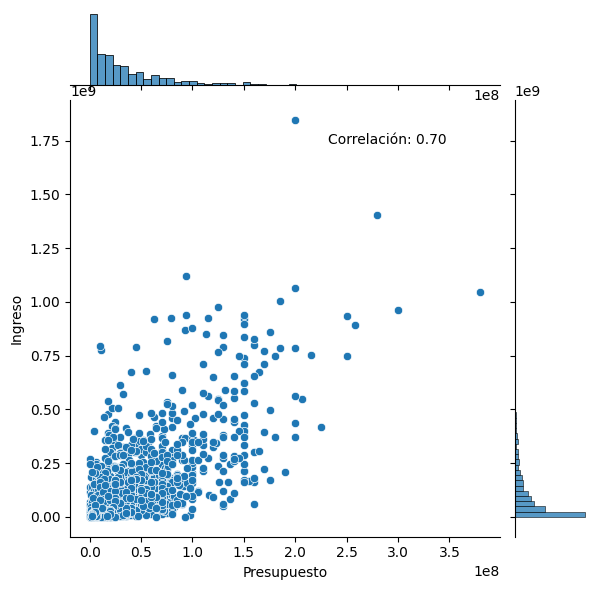

In [63]:
jointplot = sns.jointplot(x='budget', y='revenue', data=metadata[metadata['return'].notnull()])
# Obtener el coeficiente de correlación
correlation = metadata['budget'].corr(metadata['revenue'])
# Agregar el texto con el valor de correlación
jointplot.ax_joint.annotate(f'Correlación: {correlation:.2f}', xy=(0.6, 0.9), xycoords='axes fraction')
# Establecer etiquetas de los ejes
plt.xlabel('Presupuesto')
plt.ylabel('Ingreso')
# Mostrar el gráfico
plt.show()


Películas más caras

In [64]:
expensive = metadata[metadata['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(10)
expensive = expensive.rename(columns={'title': 'Título', 'budget': 'Presupuesto', 'revenue': 'Ingresos', 'return': 'Rendimiento', 'year': 'Año'})
expensive

,Título,Presupuesto,Ingresos,Rendimiento,Año
3888,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
2927,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
5394,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
2915,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
4928,X-Men: Days of Future Past,250000000.0,7.478628e+08,2.991451,2014
3367,Harry Potter and the Half-Blood Prince,250000000.0,9.339592e+08,3.735837,2009
3161,The Chronicles of Narnia: Prince Caspian,225000000.0,4.196514e+08,1.865117,2008
4203,The Amazing Spider-Man,215000000.0,7.522159e+08,3.498678,2012
2611,King Kong,207000000.0,5.500000e+08,2.657005,2005
2705,Pirates of the Caribbean: Dead Man's Chest,200000000.0,1.065660e+09,5.328299,2006


##### Género

In [65]:
def parse_genres(genres_str):
    genres = json.loads(genres_str.replace("'", "\""))
    genres_list = [g['name'] for g in genres]
    return genres_list

generos = pd.DataFrame(columns=['genres'])
generos['genres'] = metadata['genres'].apply(parse_genres)
generos.head()

,genres
0,"[Animation, Comedy, Family]"
1,"[Adventure, Fantasy, Family]"
2,"[Action, Crime, Drama, Thriller]"
3,"[Adventure, Action, Thriller]"
4,"[Action, Adventure]"


In [66]:
all_genres = np.concatenate(generos['genres'].values)
unique_genres, counts = np.unique(all_genres, return_counts=True)
genre_counts = pd.DataFrame({'genre': unique_genres, 'count': counts}).sort_values(by='count', ascending=False)

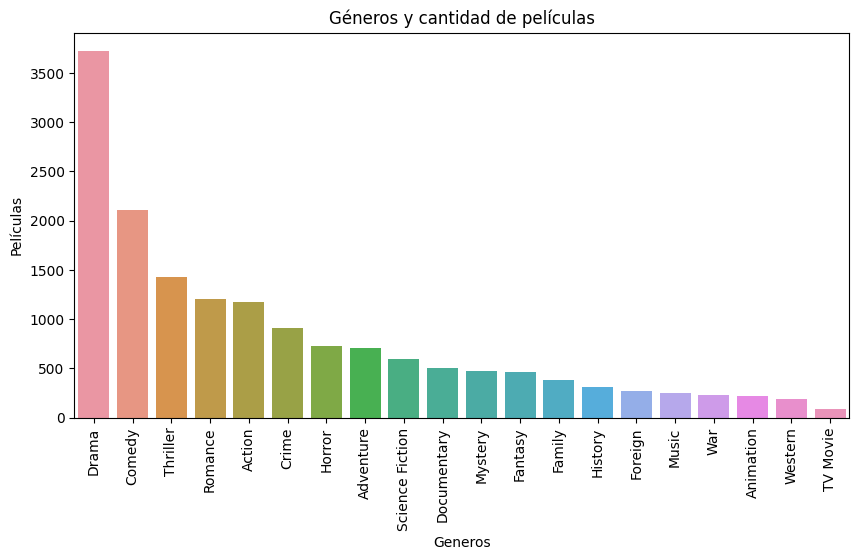

In [67]:
plt.figure(figsize=(10, 5))
sns.barplot(x='genre', y='count', data=genre_counts)
plt.title('Géneros y cantidad de películas')
plt.xlabel('Generos')
plt.ylabel('Películas')
plt.xticks(rotation=90)
plt.show()